In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Library

In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
import cv2
import torch.optim as optim
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings("ignore")
import fastai

from fastai.vision.all import *
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from typing import Tuple, Union
from collections import OrderedDict
from torch.cuda.amp import autocast
from glob import glob

# Set up training

In [3]:
SEED = 85
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

# Split and Preprocess Data

In [4]:
labels_train_val = pd.read_csv('/kaggle/input/data/train_val_list.txt')
labels_train_val.columns = ['Image_Index']
labels_test = pd.read_csv('/kaggle/input/data/test_list.txt')
labels_test.columns = ['Image_Index']
disease_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']
# NIH Dataset Labels CSV File 
labels_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
labels_df.columns = ['Image_Index', 'Finding_Labels', 'Follow_Up_#', 'Patient_ID',
                  'Patient_Age', 'Patient_Gender', 'View_Position',
                  'Original_Image_Width', 'Original_Image_Height',
                  'Original_Image_Pixel_Spacing_X',
                  'Original_Image_Pixel_Spacing_Y', 'dfd']
# One hot encoding
for diseases in tqdm(disease_labels): 
    labels_df[diseases] = labels_df['Finding_Labels'].map(lambda result: 1 if diseases in result else 0)

# labels_df.to_csv('/kaggle/working/newData.csv')
labels_df=labels_df[labels_df.Finding_Labels != 'No Finding']
# #labels_df.head(3)

100%|██████████| 14/14 [00:00<00:00, 29.05it/s]


In [5]:
labels_df['Finding_Labels'] = labels_df['Finding_Labels'].apply(lambda s: [l for l in str(s).split('|')])

num_glob = glob('/kaggle/input/data/*/images/*.png')
img_path = {os.path.basename(x): x for x in num_glob}

labels_df['Paths'] = labels_df['Image_Index'].map(img_path.get)
labels_df.head()

,Image_Index,Finding_Labels,Follow_Up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,Original_Image_Width,Original_Image_Height,Original_Image_Pixel_Spacing_X,...,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,Paths
0,00000001_000.png,[Cardiomegaly],0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_000.png
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_001.png
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,...,0,0,1,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_002.png
4,00000003_000.png,[Hernia],0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,0,1,/kaggle/input/data/images_001/images/00000003_000.png
5,00000003_001.png,[Hernia],1,3,74,F,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,1,/kaggle/input/data/images_001/images/00000003_001.png


In [6]:
unique_patients = np.unique(labels_df['Patient_ID'])
len(unique_patients)

14402

In [7]:
from sklearn.model_selection import train_test_split

# train-70
# val-10
# test-20
train_val_df_patients, test_df_patients = train_test_split(unique_patients, 
                                   test_size = 0.2,
                                   random_state = SEED,
                                    shuffle= True
                                   )
len(train_val_df_patients)

11521

In [8]:
train_val_df = labels_df[labels_df['Patient_ID'].isin(train_val_df_patients)]
train_val_df.head()

,Image_Index,Finding_Labels,Follow_Up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,Original_Image_Width,Original_Image_Height,Original_Image_Pixel_Spacing_X,...,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,Paths
0,00000001_000.png,[Cardiomegaly],0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_000.png
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_001.png
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,...,0,0,1,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_002.png
12,00000004_000.png,"[Mass, Nodule]",0,4,82,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,1,1,0,/kaggle/input/data/images_001/images/00000004_000.png
19,00000005_006.png,[Infiltration],6,5,70,F,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,/kaggle/input/data/images_001/images/00000005_006.png


In [9]:
labels_df.shape
print('train_val size', train_val_df.shape[0])
print('test size', labels_df.shape[0] - train_val_df.shape[0])

train_val size 41721
test size 10038


In [10]:
item_transforms = [
    Resize((224, 224)),
]

batch_transforms = [
    Flip(),
    Rotate(),
    Normalize.from_stats(*imagenet_stats),
]


def get_x(row):
    return row['Paths']

def get_y(row):
    labels = row[disease_labels].tolist()
    return labels

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True,vocab=disease_labels)),
                   splitter=RandomSplitter(valid_pct=0.125, seed=SEED),
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=item_transforms,
                   batch_tfms=batch_transforms
                  )
dls = dblock.dataloaders(train_val_df, bs=64)

# CBAM-Enhanced CNN Framework

## CBAM Module

In [ ]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
        )
        self.pool_types = pool_types

    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                avg_pool = F.avg_pool2d(x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp(avg_pool)
            elif pool_type == 'max':
                max_pool = F.max_pool2d(x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp(max_pool)
            elif pool_type == 'lp':
                lp_pool = F.lp_pool2d(x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp(lp_pool)
            elif pool_type == 'lse':
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp(lse_pool)

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = torch.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1,
                                 padding=(kernel_size - 1) // 2, relu=False)

    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out)
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial = no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()

    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

## DenseNet121-based Feature Extractor

### CBAM after DenseBlock 1 2 3 4

In [11]:
class DenseNet121_CBAM_full(nn.Module):
    def __init__(self, num_classes=1000, dropout=0.5):
        super(DenseNet121_CBAM_full, self).__init__()
        densenet = models.densenet121(pretrained=True)
        self.features = densenet.features

        self.att_block1 = CBAM(256)
        self.att_block2 = CBAM(512)
        self.att_block3 = CBAM(1024)
        self.att_block4 = CBAM(1024)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features.conv0(x)
        x = self.features.norm0(x)
        x = self.features.relu0(x)
        x = self.features.pool0(x)

        x = self.features.denseblock1(x)
        x = self.att_block1(x)
        x = self.features.transition1(x)

        x = self.features.denseblock2(x)
        x = self.att_block2(x)
        x = self.features.transition2(x)

        x = self.features.denseblock3(x)
        x = self.att_block3(x)
        x = self.features.transition3(x)

        x = self.features.denseblock4(x)
        x = self.att_block4(x)

        x = self.features.norm5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x
model_dense_cbam_full =  DenseNet121_CBAM_full(
    num_classes=14,
    dropout=0.5,
)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:05<00:00, 94.7MB/s] 


### CBAM after DenseBlock 3 4

In [ ]:
class DenseNet121_CBAM(nn.Module):
    def __init__(self, num_classes=1000, dropout=0.5):
        super(DenseNet121_CBAM, self).__init__()
        densenet = models.densenet121(pretrained=True)
        self.features = densenet.features

        self.att_block3 = CBAM(1024)
        self.att_block4 = CBAM(1024)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features.conv0(x)
        x = self.features.norm0(x)
        x = self.features.relu0(x)
        x = self.features.pool0(x)

        x = self.features.denseblock1(x)
        x = self.features.transition1(x)

        x = self.features.denseblock2(x)
        x = self.features.transition2(x)

        x = self.features.denseblock3(x)
        x = self.att_block3(x)
        x = self.features.transition3(x)

        x = self.features.denseblock4(x)
        x = self.att_block4(x)

        x = self.features.norm5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x
model_dense_cbam =  DenseNet121_CBAM(
    num_classes=14,
    dropout=0.5,
)

### CBAM after DenseBlock 4

In [ ]:
class DenseNet121_CBAM_after(nn.Module):
    def __init__(self, num_classes=1000, dropout=0.5):
        super(DenseNet121_CBAM_after, self).__init__()
        densenet = models.densenet121(pretrained=True)
        self.features = densenet.features

        self.cbam = CBAM(1024)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.cbam(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x
model_dense_cbam_after =  DenseNet121_CBAM_after(
    num_classes=14,
    dropout=0.5,
)

## VGG16-based Feature Extractor

### CBAM after VGGBlock 1 2 3 4 5

In [ ]:
class VGG_CBAM_full(nn.Module):
    def __init__(self, num_classes, dropout=None):
        super(VGG_CBAM_full, self).__init__()
        net = models.vgg16_bn(pretrained=True)
   
        self.conv_block1 = nn.Sequential(
            *list(net.features.children())[0:6],
            CBAM(gate_channels=64)
        )
        self.conv_block2 = nn.Sequential(
            *list(net.features.children())[7:13],
            CBAM(gate_channels=128)
        )
        self.conv_block3 = nn.Sequential(
            *list(net.features.children())[14:23],
            CBAM(gate_channels=256)
        )
        self.conv_block4 = nn.Sequential(
            *list(net.features.children())[24:33],
            CBAM(gate_channels=512)
        )
        self.conv_block5 = nn.Sequential(
            *list(net.features.children())[34:43],
            CBAM(gate_channels=512)
        )
        self.pool = nn.AvgPool2d(7, stride=1)
        self.dpt = nn.Dropout(dropout) if dropout is not None else None
        # The classifier now expects concatenated features from global pooling and cross-attention outputs.
        self.cls = nn.Linear(in_features=512, out_features=num_classes, bias=True)

        self.reset_parameters(self.cls)

    def reset_parameters(self, module):
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.)
                nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0., 0.01)
                nn.init.constant_(m.bias, 0.)

    def forward(self, x):
        # Pass input through each VGG block (with CBAM enhancement)
        block1 = self.conv_block1(x)              # output channels: 64
        pool1 = F.max_pool2d(block1, 2, 2)          # /2
        block2 = self.conv_block2(pool1)            # output channels: 128
        pool2 = F.max_pool2d(block2, 2, 2)          # /4
        block3 = self.conv_block3(pool2)            # output channels: 256
        pool3 = F.max_pool2d(block3, 2, 2)          # /8
        block4 = self.conv_block4(pool3)            # output channels: 512
        pool4 = F.max_pool2d(block4, 2, 2)          # /16
        block5 = self.conv_block5(pool4)            # output channels: 512
        pool5 = F.max_pool2d(block5, 2, 2)          # /32

        N = pool5.size(0)
        # Global features from pool5 using average pooling
        g = self.pool(pool5).view(N, 512)

        if self.dpt is not None:
            g = self.dpt(g)

        # Final classification
        out = self.cls(g)
        return out

model_vgg_cbam_full = VGG_CBAM_full(14, 0.5)

### CBAM after VGGBlock 3 4 5

In [ ]:
class VGG_CBAM(nn.Module):
    def __init__(self, num_classes, dropout=None):
        super(VGG_CBAM, self).__init__()
        net = models.vgg16_bn(pretrained=True)
        # Wrap each conv block with CBAM.
        # Note: Adjust gate_channels based on the output channels of each block.
        self.conv_block1 = nn.Sequential(
            *list(net.features.children())[0:6],
        )
        self.conv_block2 = nn.Sequential(
            *list(net.features.children())[7:13],
        )
        self.conv_block3 = nn.Sequential(
            *list(net.features.children())[14:23],
            CBAM(gate_channels=256)
        )
        self.conv_block4 = nn.Sequential(
            *list(net.features.children())[24:33],
            CBAM(gate_channels=512)
        )
        self.conv_block5 = nn.Sequential(
            *list(net.features.children())[34:43],
            CBAM(gate_channels=512)
        )
        self.pool = nn.AvgPool2d(7, stride=1)
        self.dpt = nn.Dropout(dropout) if dropout is not None else None
        # The classifier now expects concatenated features from global pooling and cross-attention outputs.
        self.cls = nn.Linear(in_features=512, out_features=num_classes, bias=True)

        self.reset_parameters(self.cls)

    def reset_parameters(self, module):
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.)
                nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0., 0.01)
                nn.init.constant_(m.bias, 0.)

    def forward(self, x):
        # Pass input through each VGG block (with CBAM enhancement)
        block1 = self.conv_block1(x)              # output channels: 64
        pool1 = F.max_pool2d(block1, 2, 2)          # /2
        block2 = self.conv_block2(pool1)            # output channels: 128
        pool2 = F.max_pool2d(block2, 2, 2)          # /4
        block3 = self.conv_block3(pool2)            # output channels: 256
        pool3 = F.max_pool2d(block3, 2, 2)          # /8
        block4 = self.conv_block4(pool3)            # output channels: 512
        pool4 = F.max_pool2d(block4, 2, 2)          # /16
        block5 = self.conv_block5(pool4)            # output channels: 512
        pool5 = F.max_pool2d(block5, 2, 2)          # /32

        N = pool5.size(0)
        # Global features from pool5 using average pooling
        g = self.pool(pool5).view(N, 512)

        if self.dpt is not None:
            g = self.dpt(g)

        # Final classification
        out = self.cls(g)
        return out

model_vgg_cbam = VGG_CBAM(14, 0.5)

### CBAM after VGGBlock 5

In [ ]:
class VGG16_CBAM_after(nn.Module):
    def __init__(self, num_classes, dropout=0.5):
        super(VGG16_CBAM_after, self).__init__()
        base = models.vgg16_bn(pretrained=True)

        self.features = base.features

        self.cbam = CBAM(512)

        # Classification head
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout) if dropout else nn.Identity()
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)      
        x = self.cbam(x)          
        x = self.pool(x).flatten(1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x
model_vgg_cbam_after = VGG16_CBAM_after(num_classes=14, dropout=0.5)

# Training Stage 1

In [12]:
learn = Learner(
    dls,
    model_vgg_cbam_after,  # adjust the model for training
    metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()],
    cbs=[
        SaveModelCallback(monitor='valid_loss', fname='best_model', min_delta=0.0001, with_opt=True),
        EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5),
        ShowGraphCallback()
    ],
    wd=0.001
)
learn.model
sum(p.numel() for p in learn.model.parameters() if p.requires_grad)

15418702

intial learning rate= 0.0004786300996784121


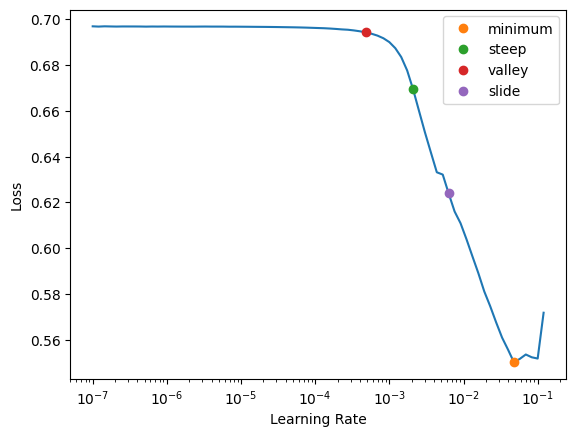

In [13]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print('intial learning rate=', lrs.valley)

In [ ]:
learn.fine_tune(freeze_epochs=3,epochs=20, base_lr=lrs.valley)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
